# Project: Running Apache Spark jobs locally

## Find spark

In [2]:
import findspark

findspark.init()
print("done")

done


## Data Source

An extract from the KDD Cup competition from the Knowledge, Discovery, and Data (KDD) conference in 1999. The data relates to computer intrusion detection events.
http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz


## Create an SparkContext sc

In [3]:
import pyspark
from pyspark.sql import SparkSession

#spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder.appName("kdd").getOrCreate()
sc = spark.sparkContext

## Fetch the data source file

In [4]:
!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz

SYSTEM_WGETRC = c:/progra~1/wget/etc/wgetrc
syswgetrc = C:\Program Files (x86)\Gow/etc/wgetrc
--2020-07-15 23:26:12--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Resolving kdd.ics.uci.edu... 128.195.1.86
Connecting to kdd.ics.uci.edu|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2,0M) [application/x-gzip]
Saving to: `kddcup.data_10_percent.gz.5'

     0K .......... .......... .......... .......... ..........  2%  145K 14s
    50K .......... .......... .......... .......... ..........  4%  287K 10s
   100K .......... .......... .......... .......... ..........  7% 4,25M 7s
   150K .......... .......... .......... .......... ..........  9% 5,72M 5s
   200K .......... .......... .......... .......... .......... 11%  311K 5s
   250K .......... .......... .......... .......... .......... 14% 4,72M 4s
   300K .......... .......... .......... .......... .......... 16%  321K 4s
   350K .......... .......... .......... ..

## Reading in data

In [6]:
from pyspark.sql import SparkSession, SQLContext, Row

data_file = "kddcup.data_10_percent.gz"
raw_rdd = sc.textFile(data_file).cache()
raw_rdd.take(2)

['0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.',
 '0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.']

In [7]:
len([0,'tcp','http','SF',181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,'normal'])

42

## Parse Data With Prepared Schema

In [8]:
csv_rdd = raw_rdd.map(lambda row: row.split(","))
parsed_rdd = csv_rdd.map(lambda r: Row(
    duration=int(r[0]),
    protocol_type=r[1],
    service=r[2],
    flag=r[3],
    src_bytes=int(r[4]),
    dst_bytes=int(r[5]),
    wrong_fragment=int(r[7]),
    urgent=int(r[8]),
    hot=int(r[9]),
    num_failed_logins=int(r[10]),
    num_compromised=int(r[12]),
    su_attempted=r[14],
    num_root=int(r[15]),
    num_file_creations=int(r[16]),
    label=r[-1]
    )
)
parsed_rdd.take(5)

[Row(dst_bytes=5450, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=181, su_attempted='0', urgent=0, wrong_fragment=0),
 Row(dst_bytes=486, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=239, su_attempted='0', urgent=0, wrong_fragment=0),
 Row(dst_bytes=1337, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=235, su_attempted='0', urgent=0, wrong_fragment=0),
 Row(dst_bytes=1337, duration=0, flag='SF', hot=0, label='normal.', num_compromised=0, num_failed_logins=0, num_file_creations=0, num_root=0, protocol_type='tcp', service='http', src_bytes=219, su_attempted='0', urgent=0, wrong_fragment=0),
 Row(dst_bytes=2032, duration=0, flag

## Create a Spark SQL Context and a df with SQL Context

In [9]:
sqlContext = SQLContext(sc)
df = sqlContext.createDataFrame(parsed_rdd)

## Spark Analysis

In [11]:
d1=df.groupBy('protocol_type').count()
d1.orderBy('count',ascending=True).show()

+-------------+------+
|protocol_type| count|
+-------------+------+
|          udp| 20354|
|          tcp|190065|
|         icmp|283602|
+-------------+------+



In [12]:
type(df)

pyspark.sql.dataframe.DataFrame

In [13]:
sqlContext = SQLContext(sc)
df = sqlContext.createDataFrame(parsed_rdd)
connections_by_protocol = df.groupBy('protocol_type').count().orderBy('count', ascending=False)
connections_by_protocol.show()

+-------------+------+
|protocol_type| count|
+-------------+------+
|         icmp|283602|
|          tcp|190065|
|          udp| 20354|
+-------------+------+



In [30]:
#df.registerTempTable("connections")  used in old version 2.xx
df.createOrReplaceTempView("connections")
df.attack_stats = sqlContext.sql("""
    SELECT
      protocol_type,
      CASE label
        WHEN 'normal.' THEN 'no attack'
        ELSE 'attack'
      END AS state,
      COUNT(*) as total_freq,
      ROUND(AVG(src_bytes), 2) as mean_src_bytes,
      ROUND(AVG(dst_bytes), 2) as mean_dst_bytes,
      ROUND(AVG(duration), 2) as mean_duration,
      SUM(num_failed_logins) as total_failed_logins,
      SUM(num_compromised) as total_compromised,
      SUM(num_file_creations) as total_file_creations,
      SUM(su_attempted) as total_root_attempts,
      SUM(num_root) as total_root_acceses
    FROM connections
    GROUP BY protocol_type, state
    ORDER BY 3 DESC
    """)
df.attack_stats.show()

+-------------+---------+----------+--------------+--------------+-------------+-------------------+-----------------+--------------------+-------------------+------------------+
|protocol_type|    state|total_freq|mean_src_bytes|mean_dst_bytes|mean_duration|total_failed_logins|total_compromised|total_file_creations|total_root_attempts|total_root_acceses|
+-------------+---------+----------+--------------+--------------+-------------+-------------------+-----------------+--------------------+-------------------+------------------+
|         icmp|   attack|    282314|        932.14|           0.0|          0.0|                  0|                0|                   0|                0.0|                 0|
|          tcp|   attack|    113252|       9880.38|        881.41|        23.19|                 57|             2269|                  76|                1.0|               152|
|          tcp|no attack|     76813|       1439.31|       4263.97|        11.08|                 18|     

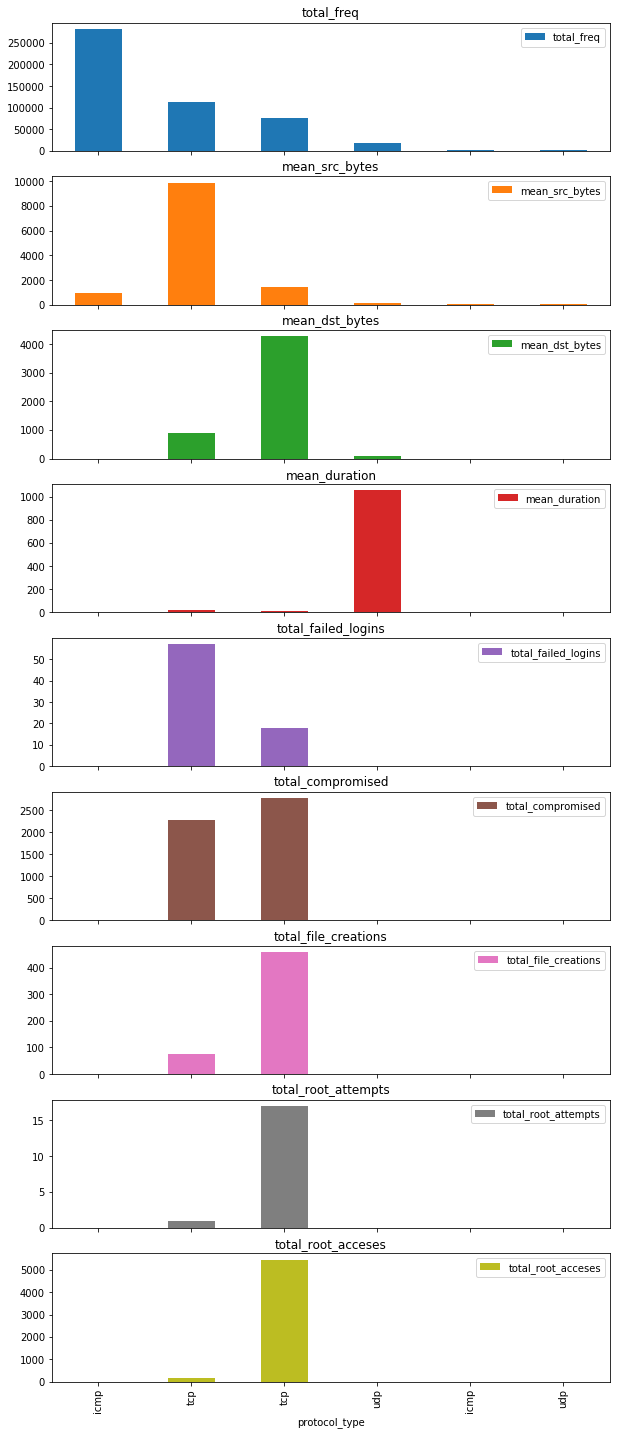

In [32]:
%matplotlib inline
ax = df.attack_stats.toPandas().plot.bar(x='protocol_type', subplots=True, figsize=(10,25))

In [33]:
from pyspark.sql import Row
df = sc.parallelize([Row(visit_dts='5/1/2018 3:48:14 PM')]).toDF()
import pyspark.sql.functions as f
web = df.withColumn("web_datetime", f.from_unixtime(f.unix_timestamp("visit_dts",'MM/dd/yyyy hh:mm:ss aa'),'MM/dd/yyyy HH:mm:ss'))
web.show()

+-------------------+------------+
|          visit_dts|web_datetime|
+-------------------+------------+
|5/1/2018 3:48:14 PM|        null|
+-------------------+------------+

